In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Change directory to a specific path
import os
specific_path = '/content/drive/MyDrive/BIG DATA'


os.chdir(specific_path)

# Check the contents of the directory
print(os.listdir('.'))

['places_final.csv', 'weather_category_mapping.json']


In [ ]:
!pip install pyspark

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, lit, trim, isnan, desc, when
from pyspark.sql.types import StringType, DoubleType
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.clustering import KMeans
import requests, json, math
from pyspark.ml.feature import MinMaxScaler
from pyspark.sql.functions import format_number
from pyspark.sql.functions import regexp_replace
from pyspark.sql import functions as F
from functools import reduce
from pyspark.ml.evaluation import ClusteringEvaluator
from sklearn.metrics import silhouette_score, adjusted_rand_score
from matplotlib import pyplot as plt

In [ ]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("Weather-Based Place Recommendations with Address") \
    .getOrCreate()

In [ ]:
# fetch addresses from latitude and longitude
def get_address(latitude, longitude):
    try:
        user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36"
        headers = {'User-Agent': user_agent}
        url = f"https://nominatim.openstreetmap.org/reverse?lat={latitude}&lon={longitude}&format=json"
        response = requests.get(url, headers=headers)
        json_data = json.loads(response.text)
        address = json_data.get("display_name")
        return address
    except Exception as e:
        return None


In [ ]:
# Haversine formula
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.asin(math.sqrt(a))
    r = 3956
    return c * r

In [ ]:
# Load data
places_dataset = os.path.join(specific_path, 'places_final.csv')
df = spark.read.csv(places_dataset, header=True, inferSchema=True)
df = df.select(
    col("Name of the Place").alias("name"),
    col("Type").alias("category"),
    col("Latitude").alias("latitude"),
    col("Longitude").alias("longitude"),
    col("Ratings").alias("ratings"),
    col("Open and Closing Time").alias("Open and Closing Time")
).na.drop(subset=["latitude", "longitude"])

#df = df.withColumn("latitude", col("latitude").cast("double")).withColumn("longitude", col("longitude").cast("double"))


In [ ]:
df = df.withColumn("latitude", format_number("latitude", 6).cast("double"))
df = df.withColumn("longitude", format_number("longitude", 6).cast("double"))

In [ ]:
df = df.withColumn('name', regexp_replace('name', r'[^\w\s]', ''))\
               .withColumn('name', regexp_replace('name', ' +', ' '))
df.count()

46272

## **Exploratory Data Analysis**

In [ ]:
blanks_count = df.agg(
    *[(F.count(F.when(F.col(c).isNull() | (F.trim(F.col(c)) == ""), c))).alias(c) for c in df.columns]
).collect()

total_blanks = sum([row[c] for row in blanks_count for c in df.columns])

print(f"Total number of blank and Null rows: {total_blanks}")

Total number of blank and Null rows: 3364


In [ ]:
df.count()

46272

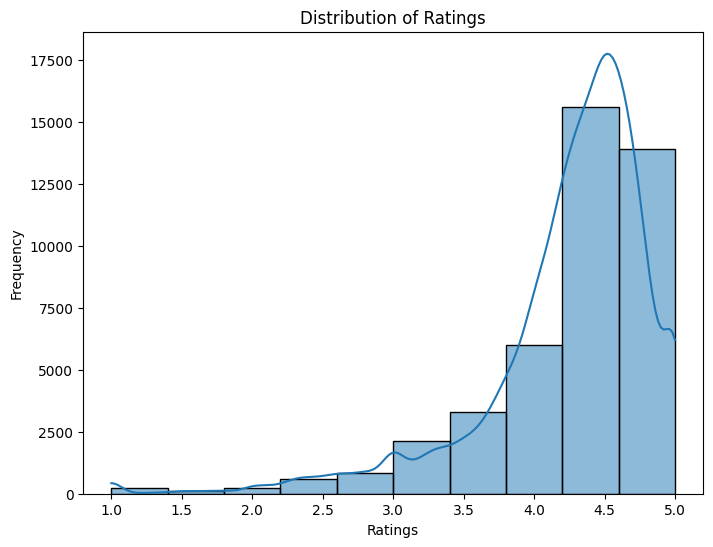

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pandas_df = df.toPandas()
# Plot distribution for ratings
plt.figure(figsize=(8, 6))
sns.histplot(pandas_df["ratings"], bins=10, kde=True)
plt.title("Distribution of Ratings")
plt.xlabel("Ratings")
plt.ylabel("Frequency")
plt.show()


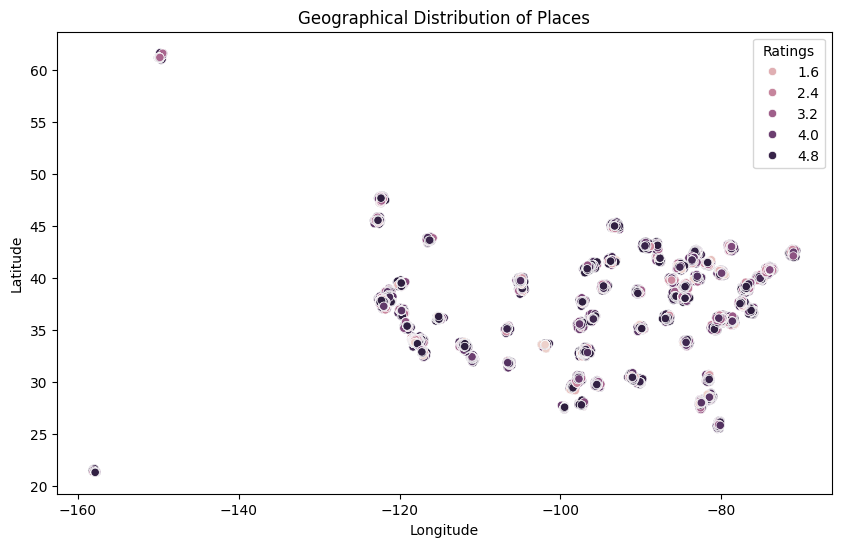

In [ ]:

# Plot distribution for latitude and longitude
plt.figure(figsize=(10, 6))
sns.scatterplot(x="longitude", y="latitude", hue="ratings", data=pandas_df)
plt.title("Geographical Distribution of Places")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Ratings")
plt.show()



Correlation Matrix:


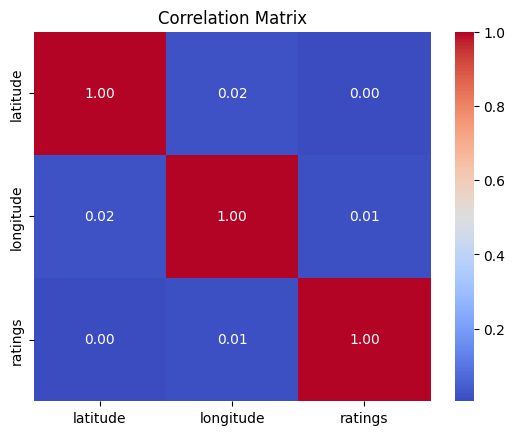

In [ ]:

# Correlation Analysis
print("\nCorrelation Matrix:")
corr_matrix = pandas_df[["latitude", "longitude", "ratings"]].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


## **Pre-Processing**

In [ ]:
df

DataFrame[name: string, category: string, latitude: double, longitude: double, ratings: double, Open and Closing Time: string]

In [ ]:
df = df.withColumn('open_24_hours', when(col('Open and Closing Time').contains('Open 24 hours'), 1).otherwise(0))

df = df.drop('Open and Closing Time')

df.show()

+--------------------+----------+---------+----------+-------+-------------+
|                name|  category| latitude| longitude|ratings|open_24_hours|
+--------------------+----------+---------+----------+-------+-------------+
| The Frederick Hotel|restaurant|40.715614|-74.008967|    4.2|            1|
|           NOMO SOHO|restaurant|40.719814|-74.000073|    4.0|            1|
|Kimpton Hotel Eventi|restaurant|40.747022|-73.990033|    4.4|            1|
|Union Hotel Brooklyn|restaurant|40.679225|-73.983162|    2.7|            0|
|Park Lane Hotel N...|restaurant|40.765073|-73.975263|    4.0|            0|
|      The Mark Hotel|restaurant|40.775271|-73.963399|    4.5|            1|
|   Hotel Belleclaire|restaurant|40.782425| -73.98116|    4.0|            1|
|           Connollys|restaurant|40.757368| -73.98358|    4.4|            0|
|Artichoke Basille...|restaurant|    40.73|-74.000728|    4.4|            0|
|American Girl Pla...|restaurant|40.759993|-73.977803|    4.5|            0|

In [ ]:

condition = reduce(lambda a, b: a | b, (col(c).isNull() | (trim(col(c)) == "") for c in df.columns))

# Now, filter out the rows
df = df.filter(~condition)

df = df.dropDuplicates()
df.count()

31894

In [ ]:
weather_dataset = os.path.join(specific_path, 'weather_category_mapping.json')


In [ ]:
import json

# Load from JSON
with open(weather_dataset, 'r') as json_file:
    weather_category_mapping_from_json = json.load(json_file)

# Print loaded data
print(weather_category_mapping_from_json)


{'Clear': ['park', 'zoo', 'amusement_park', 'aquarium'], 'Partly cloudy': ['park', 'zoo', 'museum', 'art_gallery'], 'Cloudy': ['museum', 'art_gallery', 'shopping_mall', 'movie_theater'], 'Overcast': ['museum', 'art_gallery', 'shopping_mall'], 'Mist': ['museum', 'art_gallery', 'cafe'], 'Patchy rain possible': ['shopping_mall', 'movie_theater', 'museum'], 'Patchy snow possible': ['indoor_ski_resort', 'mall', 'movie_theater'], 'Patchy sleet possible': ['shopping_mall', 'indoor_pool', 'gym'], 'Patchy freezing drizzle possible': ['spa', 'hotel', 'indoor_pool'], 'Thundery outbreaks possible': ['cinema', 'shopping_mall', 'indoor_recreation_center'], 'Blowing snow': ['indoor_ski_resort', 'spa', 'hotel'], 'Blizzard': ['indoor_ski_resort', 'hotel'], 'Fog': ['spa', 'hotel', 'night_club', 'restaurant'], 'Freezing fog': ['spa', 'hotel', 'cinema'], 'Patchy light drizzle': ['shopping_mall', 'movie_theater', 'art_gallery'], 'Light drizzle': ['museum', 'art_gallery', 'cafe'], 'Freezing drizzle': ['spa'

In [ ]:
df

DataFrame[name: string, category: string, latitude: double, longitude: double, ratings: double, open_24_hours: int]

In [ ]:
features = df[['Latitude', 'Longitude', 'Ratings']]

scaler = StandardScaler()

features

DataFrame[Latitude: double, Longitude: double, Ratings: double, open_24_hours: int]

## **Model Development**

## Optimal K-Value

In [ ]:
# VectorAssembler to combine features
assemblerInputs = ["latitude", "longitude", "ratings"]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
df_vector = assembler.transform(df)

In [ ]:
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
scaled_df = scaler.fit(df_vector).transform(df_vector)
scaled_df.select("features", "scaledFeatures").show(truncate=False)

+---------------------------+-----------------------------------------------------------+
|features                   |scaledFeatures                                             |
+---------------------------+-----------------------------------------------------------+
|[34.049648,-118.240202,4.3]|[0.31685035041272985,0.4564633118775527,0.825]             |
|[34.028156,-118.470781,3.6]|[0.3163180290019564,0.45383073503296,0.65]                 |
|[41.884064,-87.651956,4.6] |[0.5108959198202888,0.8056967986057536,0.8999999999999999] |
|[29.748351,-95.360843,4.1] |[0.21031431434366937,0.717682550067158,0.7749999999999999] |
|[29.938166,-95.311668,4.4] |[0.21501571898660585,0.718243993070783,0.8500000000000001] |
|[29.772454,-95.809691,4.2] |[0.21091130592025026,0.712557942659104,0.8]                |
|[29.549882,-95.257096,4.0] |[0.2053985643867168,0.7188670549435602,0.75]               |
|[33.454347,-111.885611,4.0]|[0.3021057259871327,0.5290152317117807,0.75]               |
|[33.50129

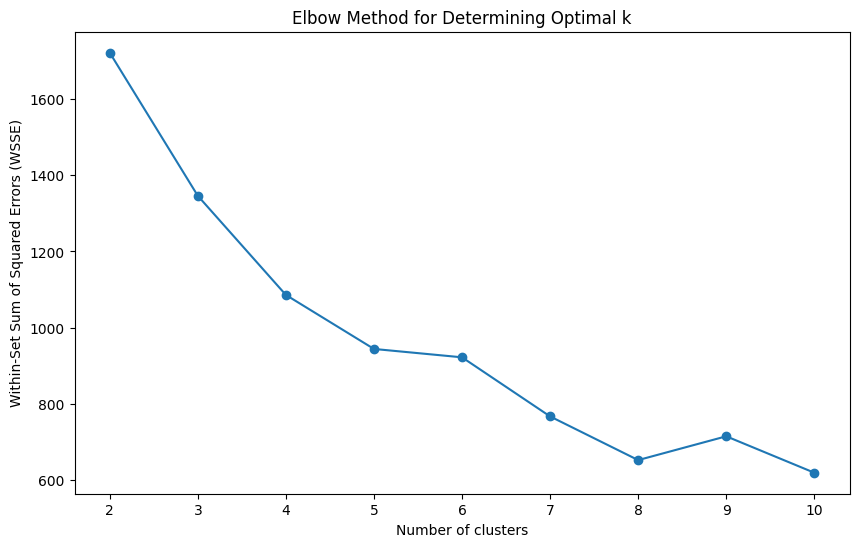

In [ ]:
def determine_optimal_k(data, max_k):
    wsse = []
    for k in range(2, max_k+1):
        kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("scaledFeatures")
        model = kmeans.fit(data)
        wsse.append(model.summary.trainingCost)  # Append WSSE for each model

    plt.figure(figsize=(10, 6))
    plt.plot(range(2, max_k+1), wsse, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Within-Set Sum of Squared Errors (WSSE)')
    plt.title('Elbow Method for Determining Optimal k')
    plt.show()

    # Find the elbow point manually or use a more sophisticated method
    return wsse

optimal_k = determine_optimal_k(scaled_df, 10)  # Modify 'max_k' based on your specific scenario


In [ ]:
scaled_df

DataFrame[name: string, category: string, latitude: double, longitude: double, ratings: double, open_24_hours: int, features: vector, scaledFeatures: vector]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


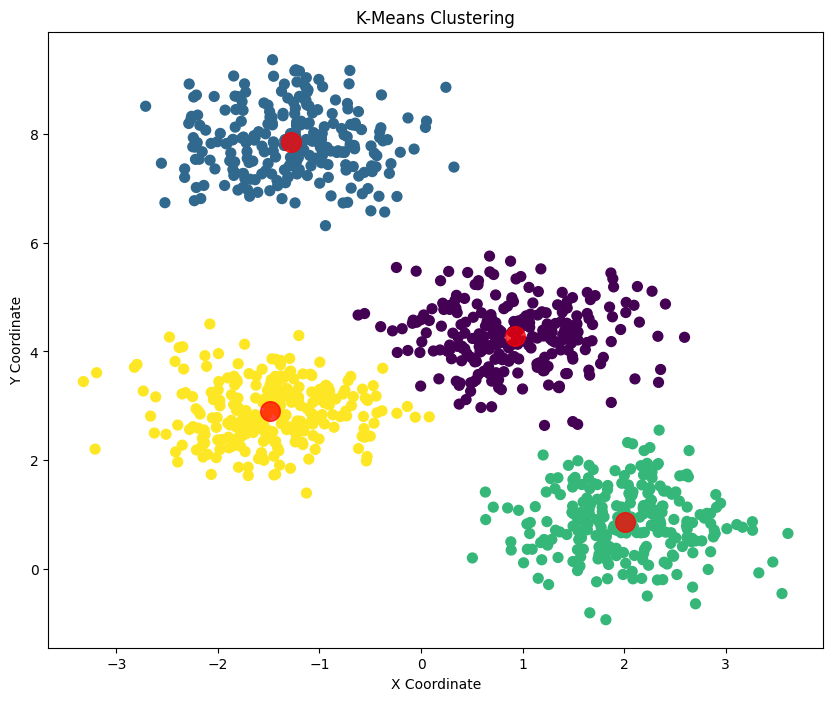

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import numpy as np

X, _ = make_blobs(n_samples=1000, centers=4, cluster_std=0.60, random_state=0)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

# Plotting the clusters
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

# Plot cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75)
plt.title('K-Means Clustering')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()


In [ ]:
from pyspark.ml.clustering import KMeans

# KMeans clustering
kmeans = KMeans(k=4, seed=1, featuresCol="scaledFeatures")
model = kmeans.fit(scaled_df)
clusters = model.transform(scaled_df)

In [ ]:
scaled_cluster = clusters.withColumnRenamed('prediction', 'cluster')

scaled_cluster.show()

+--------------------+--------------+---------+-----------+-------+-------------+--------------------+--------------------+-------+
|                name|      category| latitude|  longitude|ratings|open_24_hours|            features|      scaledFeatures|cluster|
+--------------------+--------------+---------+-----------+-------+-------------+--------------------+--------------------+-------+
|Miyako Hotel Los ...|         hotel|34.049648|-118.240202|    4.3|            1|[34.049648,-118.2...|[0.31685035041272...|      1|
|Bay Club Santa Mo...|           spa|34.028156|-118.470781|    3.6|            0|[34.028156,-118.4...|[0.31631802900195...|      1|
|La Colombe Coffee...|          cafe|41.884064| -87.651956|    4.6|            0|[41.884064,-87.65...|[0.51089591982028...|      3|
|Holiday Inn Expre...|         hotel|29.748351| -95.360843|    4.1|            0|[29.748351,-95.36...|[0.21031431434366...|      0|
|Houston Interacti...|           zoo|29.938166| -95.311668|    4.4|         

In [ ]:
selected_df = scaled_cluster.select("name", "category", "latitude", "longitude", "ratings", "cluster")
selected_df.show()

+--------------------+--------------+---------+-----------+-------+-------+
|                name|      category| latitude|  longitude|ratings|cluster|
+--------------------+--------------+---------+-----------+-------+-------+
|Miyako Hotel Los ...|         hotel|34.049648|-118.240202|    4.3|      1|
|Bay Club Santa Mo...|           spa|34.028156|-118.470781|    3.6|      1|
|La Colombe Coffee...|          cafe|41.884064| -87.651956|    4.6|      3|
|Holiday Inn Expre...|         hotel|29.748351| -95.360843|    4.1|      0|
|Houston Interacti...|           zoo|29.938166| -95.311668|    4.4|      0|
|   AMC Katy Mills 20| movie_theater|29.772454| -95.809691|    4.2|      0|
|City of Pearland ...|     city_hall|29.549882| -95.257096|    4.0|      0|
|      Casino Arizona|        casino|33.454347|-111.885611|    4.0|      1|
|        Maya Dayclub|    night_club|33.501291|-111.922815|    3.8|      1|
|Dream City Church...|        church|33.609912|-112.032085|    4.7|      1|
|The Frankli

In [ ]:

# API key configuration for weather data
api_key = 'API_KEY'
location = input("Enter your City location : ")
weather_url = f'http://api.weatherapi.com/v1/current.json?key={api_key}&q={location}&aqi=no'



# Fetch weather data from API
response = requests.get(weather_url)
weather_data = response.json()
user_latitude = weather_data['location']['lat']
user_longitude = weather_data['location']['lon']
current_weather = weather_data['current']['condition']['text']


haversine_udf = udf(haversine, DoubleType())
get_address_udf = udf(get_address, StringType())

selected_df = selected_df.withColumn("distance", haversine_udf(lit(user_longitude), lit(user_latitude), col("longitude"), col("latitude")))

recommended_categories = weather_category_mapping_from_json.get(current_weather, ["museum", "shopping_mall", "movie_theater"])  # Default categories

# Sort places by distance and ratings
recommendations = selected_df.orderBy("distance", col("ratings").desc())
filtered_recommendations = recommendations.filter(col("category").isin(recommended_categories)).withColumn("address", get_address_udf(col("latitude"), col("longitude")))

filtered_recommendations.select("name", "category", "ratings", "distance", "address").show(5, truncate=False)

Enter your City location : San Jose
+--------------------------------------------------+-----------+---------+-----------+-------+-------+------------------+--------------------------------------------------------------------------------------------------------------------------------------------+
|name                                              |category   |latitude |longitude  |ratings|cluster|distance          |address                                                                                                                                     |
+--------------------------------------------------+-----------+---------+-----------+-------+-------+------------------+--------------------------------------------------------------------------------------------------------------------------------------------+
|San Jose Museum of Art                            |museum     |37.333726|-121.889925|4.2    |1      |0.6976684797821999|San José Museum of Art, 110, South Market Street, Down

## **Evaluation**

In [ ]:
evaluator = ClusteringEvaluator(predictionCol='prediction')
silhouette = evaluator.evaluate(cluster)
print(f"Silhouette Score: {silhouette}")

Silhouette Score: 0.6080986188849464


## **Deployment**

In [ ]:
csv_path = "/content/drive/MyDrive/BIG DATA/final_place_df.csv"

# Save the DataFrame to a CSV file
selected_df.write.csv(path=csv_path, mode="overwrite", header=True)

In [ ]:
model_path = "/content/drive/MyDrive/BIG DATA/model"
model.write().overwrite().save(model_path)

In [ ]:
from pyspark.ml.clustering import KMeansModel

loaded_model = KMeansModel.load(model_path)

transformed_df = loaded_model.transform(scaled_df)